<a href="https://colab.research.google.com/github/deepthyjayaraj/AI_ML/blob/master/automating_port_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automating Port Operations**

Course-end Project 3


**Description**

**Project Statement**:
Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows.
●    Buoy
●    Cruise_ship
●    Ferry_boat
●    Freight_boar
●    Gondola
●    Inflatable_boat
●    Kayak
●    Paper_boat
●    Sailboat
Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

As a deep learning engineer, your task is to:
1.    Build a CNN network to classify the boat.
2.    Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

In [2]:
!unzip /content/Automating_Port_Operations_Dataset.zip

Archive:  /content/Automating_Port_Operations_Dataset.zip
   creating: Automating_Port_Operations_Dataset/
  inflating: __MACOSX/._Automating_Port_Operations_Dataset  
  inflating: Automating_Port_Operations_Dataset/.DS_Store  
  inflating: __MACOSX/Automating_Port_Operations_Dataset/._.DS_Store  
   creating: Automating_Port_Operations_Dataset/boat_type_classification_dataset/
  inflating: __MACOSX/Automating_Port_Operations_Dataset/._boat_type_classification_dataset  
   creating: Automating_Port_Operations_Dataset/dataset/
  inflating: __MACOSX/Automating_Port_Operations_Dataset/._dataset  
   creating: Automating_Port_Operations_Dataset/boat_type_classification_dataset/buoy/
  inflating: __MACOSX/Automating_Port_Operations_Dataset/boat_type_classification_dataset/._buoy  
   creating: Automating_Port_Operations_Dataset/boat_type_classification_dataset/gondola/
  inflating: __MACOSX/Automating_Port_Operations_Dataset/boat_type_classification_dataset/._gondola  
   creating: Automati

In [3]:
# 1.0 Import Libraries
import os
import pathlib
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [6]:
# Define the base directory where the unzipped data is located
original_data_dir = pathlib.Path('/content/Automating_Port_Operations_Dataset/boat_type_classification_dataset')

In [7]:
# Get all class names from the dataset directory
# Ensure class names are sorted to maintain consistency in label mapping
class_names = sorted([item.name for item in original_data_dir.iterdir() if item.is_dir()])
num_classes = len(class_names)
print(f"Detected classes: {class_names}")
print(f"Number of classes: {num_classes}")

Detected classes: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']
Number of classes: 9


In [8]:

# Get all image paths
all_images = list(original_data_dir.glob('*/*.jpg'))
print(f"Total images found: {len(all_images)}")

Total images found: 1162


In [9]:
# Function to copy files for splitting
def copy_files(image_paths, destination_root):
    """Copies image files from source paths to a destination directory, preserving class structure."""
    for img_path in image_paths:
        label = img_path.parent.name # Get the class label from the parent directory name
        dest_dir = destination_root / label
        dest_dir.mkdir(parents=True, exist_ok=True) # Create destination directory if it doesn't exist
        shutil.copy(img_path, dest_dir) # Copy the image file

In [10]:

# --- 1.0 CNN Model Pipeline ---

# Define paths for CNN model (80:20 split)
train_dir_cnn = Path('/content/split_data_cnn/train')
test_dir_cnn = Path('/content/split_data_cnn/test')


In [11]:
# Clean up previous split data directories for CNN if they exist
# This ensures a clean slate for each run
if train_dir_cnn.exists():
    shutil.rmtree(train_dir_cnn)
if test_dir_cnn.exists():
    shutil.rmtree(test_dir_cnn)

In [12]:
# 1.1. Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.
print(f"\n--- Splitting and Organizing Data for CNN (80:20 split, random_state=43) ---")
train_images_cnn, test_images_cnn = train_test_split(all_images, test_size=0.2, shuffle=True, random_state=43)



--- Splitting and Organizing Data for CNN (80:20 split, random_state=43) ---


In [13]:
# Organize data for CNN
copy_files(train_images_cnn, train_dir_cnn)
copy_files(test_images_cnn, test_dir_cnn)

print(f"Training images for CNN: {len(train_images_cnn)}")
print(f"Test images for CNN: {len(test_images_cnn)}")

Training images for CNN: 929
Test images for CNN: 233


In [14]:

# 1.2 & 1.3 Load train, validation, and test datasets in batches of 32
# Use tf.keras.preprocessing.image_dataset_from_directory to load and normalize data.
image_size = (224, 224) # Standard image size for many CNNs
batch_size = 32 # Batch size for training

print(f"\n--- Loading Data for CNN using image_dataset_from_directory ---")
train_ds_cnn = tf.keras.utils.image_dataset_from_directory(
    train_dir_cnn, validation_split=0.2, subset='training', seed=123, # 20% of train_dir_cnn for validation
    image_size=image_size, batch_size=batch_size
)
val_ds_cnn = tf.keras.utils.image_dataset_from_directory(
    train_dir_cnn, validation_split=0.2, subset='validation', seed=123,
    image_size=image_size, batch_size=batch_size
)
test_ds_cnn = tf.keras.utils.image_dataset_from_directory(
    test_dir_cnn, image_size=image_size, batch_size=batch_size, shuffle=False # Keep order for evaluation
)



--- Loading Data for CNN using image_dataset_from_directory ---
Found 929 files belonging to 9 classes.
Using 744 files for training.
Found 929 files belonging to 9 classes.
Using 185 files for validation.
Found 233 files belonging to 9 classes.


In [15]:
# Apply normalization (image_scale=1./255)
# Rescaling pixel values from [0, 255] to [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_ds_cnn = train_ds_cnn.map(lambda x, y: (normalization_layer(x), y))
val_ds_cnn = val_ds_cnn.map(lambda x, y: (normalization_layer(x), y))
test_ds_cnn = test_ds_cnn.map(lambda x, y: (normalization_layer(x), y))

In [16]:
# One-hot encode labels for categorical_crossentropy loss
train_ds_cnn_oh = train_ds_cnn.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds_cnn_oh = val_ds_cnn.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test_ds_cnn_oh = test_ds_cnn.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [18]:
from tensorflow.keras import layers, Sequential

def build_cnn():
    """Builds a sequential CNN model as per project requirements."""
    model = Sequential([
        layers.Input(shape=(224, 224, 3)),  # Input layer
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(9, activation='softmax')  # 9 classes in output
    ])
    return model

model_cnn = build_cnn()
print(f"\n--- Custom CNN Model Architecture ---")
model_cnn.summary()



--- Custom CNN Model Architecture ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:

# 1.5. Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics.
def compile_model(model):
    """Compiles a Keras model with Adam optimizer and specified metrics."""
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

compile_model(model_cnn)

In [20]:
# 1.6. Train the model for 20 epochs and plot training loss and accuracy against epochs.
print(f"\n--- Training Custom CNN Model (20 Epochs) ---")
history_cnn = model_cnn.fit(
    train_ds_cnn_oh,
    validation_data=val_ds_cnn_oh,
    epochs=20
)



--- Training Custom CNN Model (20 Epochs) ---
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3458 - loss: 2.0263 - precision: 0.3607 - recall: 0.0244 - val_accuracy: 0.2811 - val_loss: 1.8467 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3341 - loss: 1.8380 - precision: 0.2268 - recall: 0.0056 - val_accuracy: 0.2811 - val_loss: 1.8819 - val_precision: 0.6667 - val_recall: 0.0541
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3330 - loss: 1.8254 - precision: 0.8329 - recall: 0.0159 - val_accuracy: 0.2811 - val_loss: 1.8752 - val_precision: 0.5789 - val_recall: 0.0595
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3246 - loss: 1.8316 - precision: 0.7255 - recall: 0.0304 - val_accuracy: 0.2811 - val_loss: 1.8467 - val_precision: 1.0000 - val_recall: 0.0216
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3218 - loss: 1.8187 - precision: 0.3589 - recall:

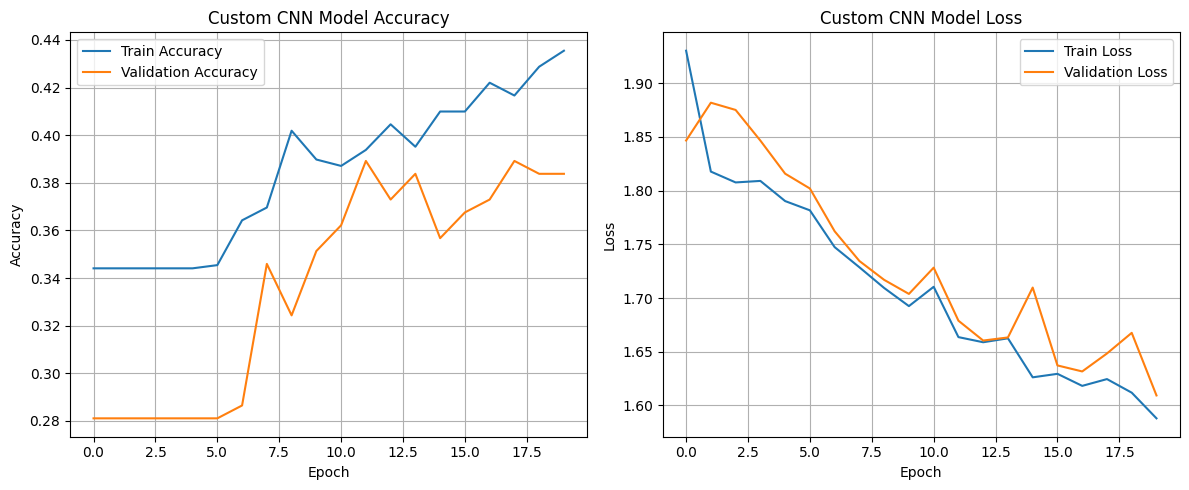

In [21]:
# Plot training loss and accuracy against epochs for CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:

# 1.7. Evaluate the model on test images and print the test loss and accuracy.
print(f"\n--- Evaluating Custom CNN Model on Test Data ---")
cnn_eval_results = model_cnn.evaluate(test_ds_cnn_oh)
print(f"CNN Test Loss: {cnn_eval_results[0]:.4f}")
print(f"CNN Test Accuracy: {cnn_eval_results[1]:.4f}")
print(f"CNN Test Precision: {cnn_eval_results[2]:.4f}")
print(f"CNN Test Recall: {cnn_eval_results[3]:.4f}")



--- Evaluating Custom CNN Model on Test Data ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.2562 - loss: 1.8824 - precision: 0.4326 - recall: 0.1124
CNN Test Loss: 1.5791
CNN Test Accuracy: 0.4163
CNN Test Precision: 0.6765
CNN Test Recall: 0.1974


In [23]:

# 1.8. Plot heatmap of the confusion matrix and print classification report (CNN).
print(f"\n--- Confusion Matrix and Classification Report for Custom CNN ---")
# Predict on the test dataset
y_pred_cnn_raw = model_cnn.predict(test_ds_cnn_oh)
y_pred_cnn = np.argmax(y_pred_cnn_raw, axis=1)



--- Confusion Matrix and Classification Report for Custom CNN ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step


In [24]:
# Get true labels from the test dataset
# Iterate through the dataset to collect all true labels
y_true_cnn = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds_cnn_oh], axis=0)

In [25]:
# Compute confusion matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

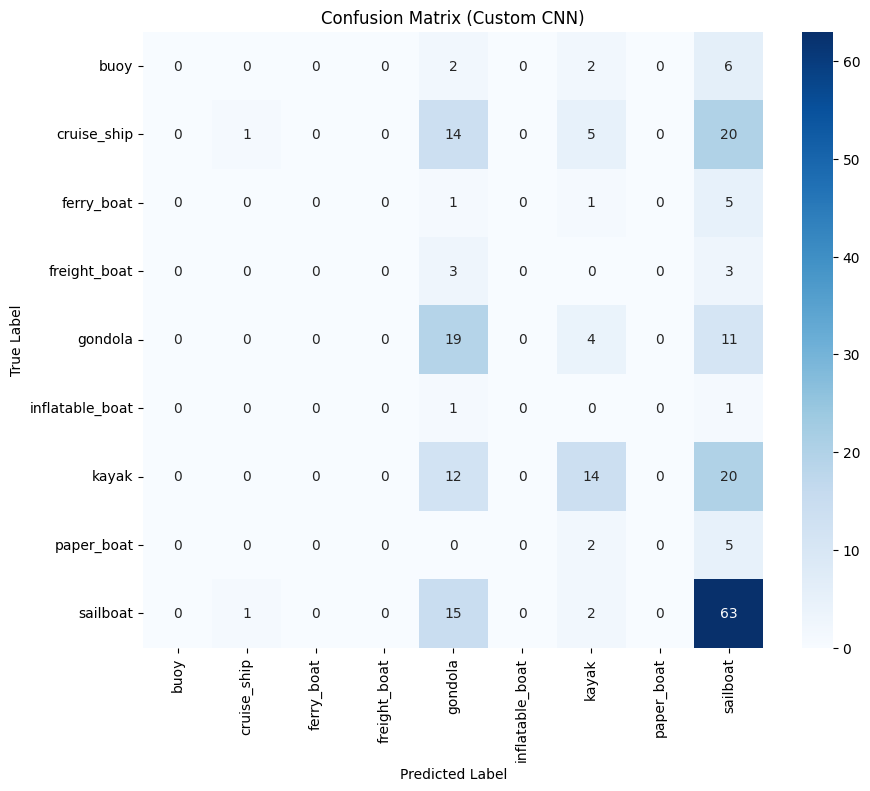

In [26]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Custom CNN)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:

# Print classification report
print("Classification Report (Custom CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

Classification Report (Custom CNN):
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        10
    cruise_ship       0.50      0.03      0.05        40
     ferry_boat       0.00      0.00      0.00         7
   freight_boat       0.00      0.00      0.00         6
        gondola       0.28      0.56      0.38        34
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.47      0.30      0.37        46
     paper_boat       0.00      0.00      0.00         7
       sailboat       0.47      0.78      0.59        81

       accuracy                           0.42       233
      macro avg       0.19      0.19      0.15       233
   weighted avg       0.38      0.42      0.34       233



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:

# --- 2.0 Transfer Learning with MobileNetV2 ---

# Define paths for MobileNetV2 model (70:30 split)
train_dir_mobile = Path('/content/split_data_mobile/train')
test_dir_mobile = Path('/content/split_data_mobile/test')

In [29]:
# Clean up previous split data directories for MobileNetV2 if they exist
if train_dir_mobile.exists():
    shutil.rmtree(train_dir_mobile)
if test_dir_mobile.exists():
    shutil.rmtree(test_dir_mobile)

In [30]:

# 2.1. Split the dataset into train and test in the ratio 70:30, with shuffle and random state=1.
print(f"\n--- Splitting and Organizing Data for MobileNetV2 (70:30 split, random_state=1) ---")
train_images_mobile, test_images_mobile = train_test_split(all_images, test_size=0.3, shuffle=True, random_state=1)

# Organize data for MobileNetV2
copy_files(train_images_mobile, train_dir_mobile)
copy_files(test_images_mobile, test_dir_mobile)

print(f"Training images for MobileNetV2: {len(train_images_mobile)}")
print(f"Test images for MobileNetV2: {len(test_images_mobile)}")


--- Splitting and Organizing Data for MobileNetV2 (70:30 split, random_state=1) ---
Training images for MobileNetV2: 813
Test images for MobileNetV2: 349


In [31]:

# 2.2 & 2.3 Load train, validation, and test datasets in batches of 32
# Use tf.keras.preprocessing.image_dataset_from_directory to load and normalize data.
print(f"\n--- Loading Data for MobileNetV2 using image_dataset_from_directory ---")
train_ds_mobile = tf.keras.utils.image_dataset_from_directory(
    train_dir_mobile, validation_split=0.2, subset='training', seed=123,
    image_size=image_size, batch_size=batch_size
)
val_ds_mobile = tf.keras.utils.image_dataset_from_directory(
    train_dir_mobile, validation_split=0.2, subset='validation', seed=123,
    image_size=image_size, batch_size=batch_size
)
test_ds_mobile = tf.keras.utils.image_dataset_from_directory(
    test_dir_mobile, image_size=image_size, batch_size=batch_size, shuffle=False # Keep order for evaluation
)



--- Loading Data for MobileNetV2 using image_dataset_from_directory ---
Found 813 files belonging to 9 classes.
Using 651 files for training.
Found 813 files belonging to 9 classes.
Using 162 files for validation.
Found 349 files belonging to 9 classes.


In [32]:
# Apply normalization (image_scale=1./255)
train_ds_mobile = train_ds_mobile.map(lambda x, y: (normalization_layer(x), y))
val_ds_mobile = val_ds_mobile.map(lambda x, y: (normalization_layer(x), y))
test_ds_mobile = test_ds_mobile.map(lambda x, y: (normalization_layer(x), y))


In [33]:
# One-hot encode labels for categorical_crossentropy
train_ds_mobile_oh = train_ds_mobile.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds_mobile_oh = val_ds_mobile.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test_ds_mobile_oh = test_ds_mobile.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [34]:
# 2.4. Build a CNN network using Keras with MobileNetV2 as the first layer.
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze the base model layers

model_mobile = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2), # Regularization
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), # Stabilizes learning
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])

print(f"\n--- MobileNetV2 Transfer Learning Model Architecture ---")
model_mobile.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- MobileNetV2 Transfer Learning Model Architecture ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [35]:
# 2.5. Compile the model
compile_model(model_mobile)

In [36]:
# 2.6. Train the model for 50 epochs and Early stopping while monitoring validation loss.
print(f"\n--- Training MobileNetV2 Model (50 Epochs with Early Stopping) ---")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history_mobile = model_mobile.fit(
    train_ds_mobile_oh,
    validation_data=val_ds_mobile_oh,
    epochs=50,
    callbacks=[early_stop]
)


--- Training MobileNetV2 Model (50 Epochs with Early Stopping) ---
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4454 - loss: 1.7772 - precision: 0.5702 - recall: 0.3322 - val_accuracy: 0.7407 - val_loss: 0.8592 - val_precision: 0.8932 - val_recall: 0.5679
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8683 - loss: 0.4313 - precision: 0.9148 - recall: 0.8134 - val_accuracy: 0.7778 - val_loss: 0.7301 - val_precision: 0.8060 - val_recall: 0.6667
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9197 - loss: 0.2789 - precision: 0.9625 - recall: 0.8726 - val_accuracy: 0.8210 - val_loss: 0.5361 - val_precision: 0.8792 - val_recall: 0.8086
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9597 - loss: 0.1515 - precision: 0.9776 - recall: 0.9434 - val_accuracy: 0.8148 - val_loss: 0.5261 - val_precision: 0.8897 - val_recall: 0.7963
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9629 - loss: 0.1423 - precision: 0.9

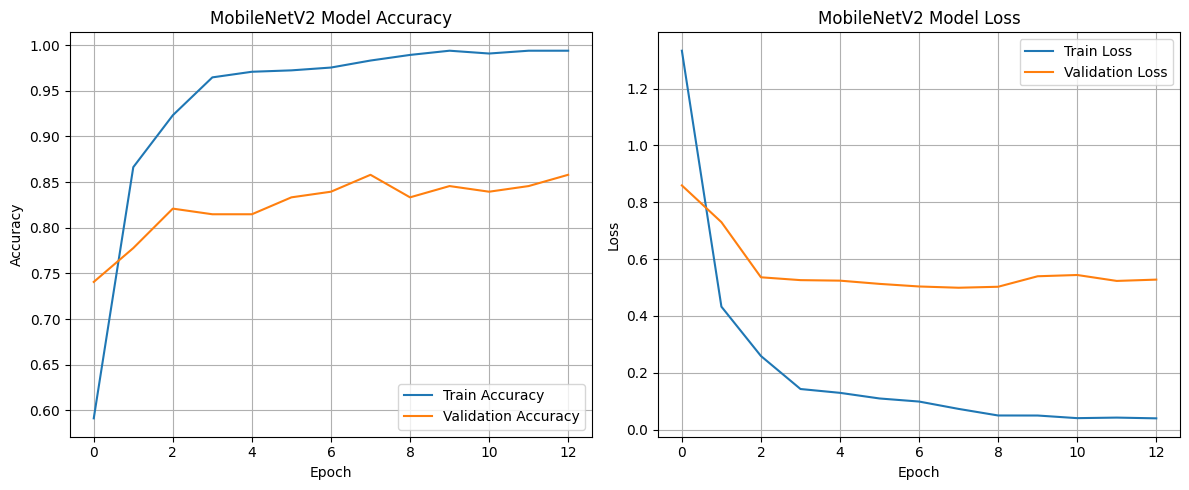

In [37]:
# 2.8. Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy (MobileNetV2).
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_mobile.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobile.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_mobile.history['loss'], label='Train Loss')
plt.plot(history_mobile.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# 2.7. Evaluate the model on test images and print the test loss and accuracy.
print(f"\n--- Evaluating MobileNetV2 Model on Test Data ---")
mobile_eval_results = model_mobile.evaluate(test_ds_mobile_oh)
print(f"MobileNetV2 Test Loss: {mobile_eval_results[0]:.4f}")
print(f"MobileNetV2 Test Accuracy: {mobile_eval_results[1]:.4f}")
print(f"MobileNetV2 Test Precision: {mobile_eval_results[2]:.4f}")
print(f"MobileNetV2 Test Recall: {mobile_eval_results[3]:.4f}")


--- Evaluating MobileNetV2 Model on Test Data ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8081 - loss: 0.6906 - precision: 0.8533 - recall: 0.7828
MobileNetV2 Test Loss: 0.5354
MobileNetV2 Test Accuracy: 0.8539
MobileNetV2 Test Precision: 0.8997
MobileNetV2 Test Recall: 0.8223



--- Confusion Matrix and Classification Report for MobileNetV2 ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


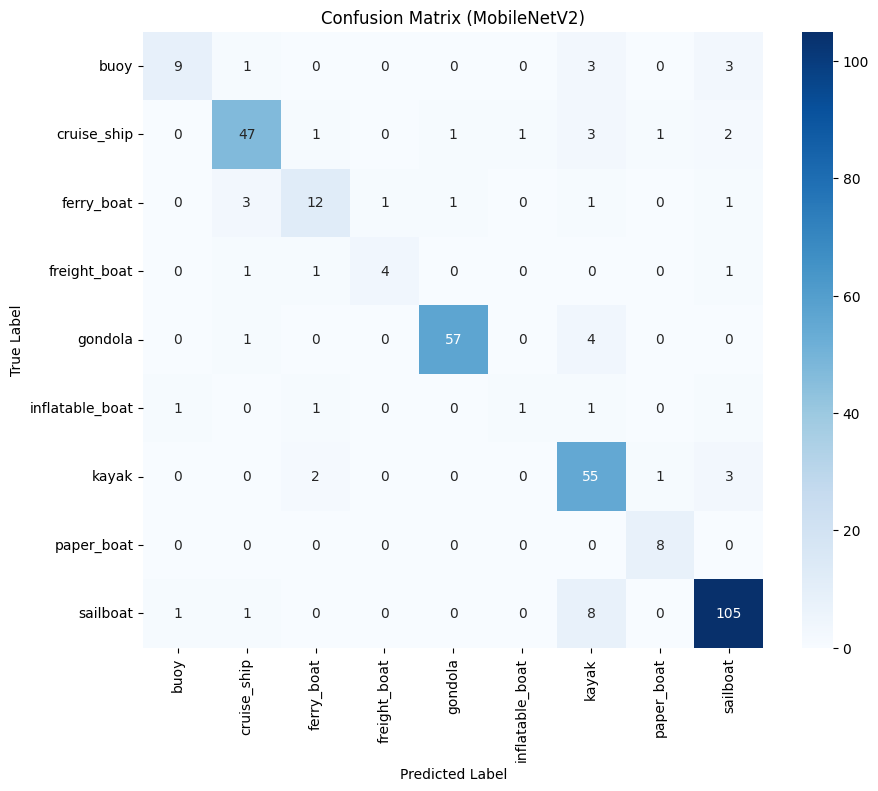

Classification Report (MobileNetV2):
                 precision    recall  f1-score   support

           buoy       0.82      0.56      0.67        16
    cruise_ship       0.87      0.84      0.85        56
     ferry_boat       0.71      0.63      0.67        19
   freight_boat       0.80      0.57      0.67         7
        gondola       0.97      0.92      0.94        62
inflatable_boat       0.50      0.20      0.29         5
          kayak       0.73      0.90      0.81        61
     paper_boat       0.80      1.00      0.89         8
       sailboat       0.91      0.91      0.91       115

       accuracy                           0.85       349
      macro avg       0.79      0.73      0.74       349
   weighted avg       0.86      0.85      0.85       349



In [39]:
# 2.9. Plot heatmap of the confusion matrix and print classification report (MobileNetV2).
print(f"\n--- Confusion Matrix and Classification Report for MobileNetV2 ---")
# Predict on the test dataset
y_pred_mobile_raw = model_mobile.predict(test_ds_mobile_oh)
y_pred_mobile = np.argmax(y_pred_mobile_raw, axis=1)

# Get true labels from the test dataset
y_true_mobile = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds_mobile_oh], axis=0)

# Compute confusion matrix
cm_mobile = confusion_matrix(y_true_mobile, y_pred_mobile)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mobile, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (MobileNetV2)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("Classification Report (MobileNetV2):")
print(classification_report(y_true_mobile, y_pred_mobile, target_names=class_names))

In [40]:
# 3.0 Comparison
print("\n--- Model Comparison ---")
# Get final validation accuracy for CNN
final_val_accuracy_cnn = history_cnn.history['val_accuracy'][-1]
# Get best validation accuracy for MobileNetV2 (due to EarlyStopping, it's the maximum value achieved)
best_val_accuracy_mobile = max(history_mobile.history['val_accuracy'])

print(f"Custom CNN Final Validation Accuracy: {final_val_accuracy_cnn:.4f}")
print(f"MobileNetV2 Best Validation Accuracy (from Early Stopping): {best_val_accuracy_mobile:.4f}")

print("\n--- Observations ---")
if best_val_accuracy_mobile > final_val_accuracy_cnn:
    print("Based on validation accuracy, the MobileNetV2 (Transfer Learning) model performed better than the custom CNN model.")
    print("This is a common outcome as MobileNetV2 leverages pre-trained weights from a large dataset (ImageNet),")
    print("allowing it to learn robust features that are highly transferable to new image classification tasks,")
    print("even with a relatively smaller custom dataset. Its lightweight architecture also makes it suitable for mobile deployment.")
else:
    print("Based on validation accuracy, the custom CNN model performed comparably or better than MobileNetV2.")
    print("While less common, this can occur depending on the dataset complexity and specific model configurations.")
    print("Further hyperparameter tuning, more extensive data augmentation, or fine-tuning the base MobileNetV2 model")
    print("could potentially improve performance for both models.")

print("\nFor Marina Pier Inc.'s goal of an automatic, bias-free system deployable on mobile devices,")
print("the MobileNetV2 transfer learning approach is generally the more suitable choice due to its")
print("expected higher accuracy and efficient architecture, directly addressing the need to recognize")
print("boat types and avoid human errors in port operations.")


--- Model Comparison ---
Custom CNN Final Validation Accuracy: 0.3838
MobileNetV2 Best Validation Accuracy (from Early Stopping): 0.8580

--- Observations ---
Based on validation accuracy, the MobileNetV2 (Transfer Learning) model performed better than the custom CNN model.
This is a common outcome as MobileNetV2 leverages pre-trained weights from a large dataset (ImageNet),
allowing it to learn robust features that are highly transferable to new image classification tasks,
even with a relatively smaller custom dataset. Its lightweight architecture also makes it suitable for mobile deployment.

For Marina Pier Inc.'s goal of an automatic, bias-free system deployable on mobile devices,
the MobileNetV2 transfer learning approach is generally the more suitable choice due to its
expected higher accuracy and efficient architecture, directly addressing the need to recognize
boat types and avoid human errors in port operations.
